# Regional indicators 2020: analysis

# Table of contents

1. [Imports](#1)
2. [Load data and 3D scatterplot](#2) <br>
3. [Kolmogorov-Smirnov tests](#3) <br>
    3a. [Regional prevalence](#3a) <br>
    3b. [Week regional trend](#3b) <br>
    3c. [Tests performed](#3c)
4. [Correlation between variables](#4)
5. [OLS regression models](#5) <br>
    5a. [Test performed against regional prevalence](#5a) <br>
    5b. [Test performed against weekly trend](#5b) <br>
6. [Standardization and final dataset](#6)
7. [Cluster analysis](#7) <br>
    7a. [Hierarchical clustering](#7a) <br>
    7b. [K-means](#7b) <br>

## Brief introduction
In this notebook we analyze the indicators for the regions from the year 2020. <br> In particular we performed a cluster analysis first of all by using the Hierarchical clustering using Ward's method and then K-Means algorithm. <br>
Before that we analyzed hypothesis of normality and linearity and we performed an OLS regression.

<a id='1'></a>
## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
#import seaborn as sns #visualizing data
#%matplotlib inline
#sns.set(color_codes=True)

#3D Scatterplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#OLS
import statsmodels.api as sm
from patsy import dmatrices

from save_dataframes import save_dataframes

# CLUSTER ANALYSIS
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
RESULT = "../results"
IMAGES = "../images"
DATA = "../DATA"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering

<a id='2'></a>
## 2. Load data and 3D scatterplot

We first load our regional indicators:

In [2]:
regions_indicators_2020=pd.read_csv("../Results/regions_indicators_2020.csv")

We rename the columns to have more easily usable colnames:

In [3]:
regions_indicators_2020.rename(columns={'Prevalence of positive cases (per 10000 residents)': 'Regional_prevalence'}, inplace=True)
regions_indicators_2020.head()

Region_name  Regional_prevalence  Week_regional_trend  Tests_performed
0         Abruzzo            14.436516            -0.015457    395475.373298
1      Basilicata             3.506527            -0.004519    336487.616899
2        Calabria             3.706226            -0.005016    249907.988448
3        Campania             4.772289            -0.003466    294161.411925
4  Emilia-Romagna            20.261557            -0.073833    602421.169776

We create a summary statistics table:

In [4]:
regions_indicators_2020.describe()

Regional_prevalence  Week_regional_trend  Tests_performed
count            20.000000            20.000000        20.000000
mean             13.053808            -0.018426    472837.691721
std              10.305329             0.032507    194796.329193
min               2.103049            -0.115968    240229.785305
25%               4.708894            -0.016609    325906.065656
50%               8.864641            -0.006078    422442.843558
75%              18.366950            -0.002336    588311.063763
max              36.824357             0.017552    869644.493998

We will plot one point for each of the italian regions:

In [5]:
labels=regions_indicators_2020["Region_name"].unique()
print(labels)

['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia' 'Toscana' 'Trentino-Alto Adige'
 'Umbria' "Valle d'Aosta" 'Veneto']


Now we create the 3D-scatterplot of the indicators:

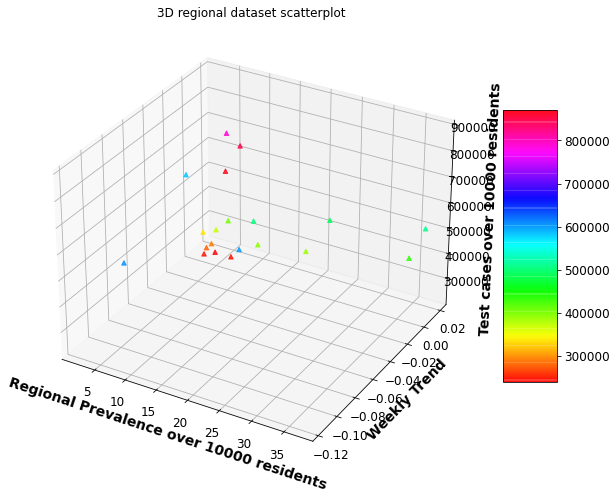

In [6]:
#creating figure
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection="3d")

#add x and y gridlines
ax.grid(b=True, color="grey", linestyle="-.", linewidth=0.3, alpha=0.2)
#creating color map
my_colmap=plt.get_cmap("hsv")

#creating plot
x=regions_indicators_2020.iloc[:,1]
y=regions_indicators_2020.iloc[:,2]
z=regions_indicators_2020.iloc[:,3]
sctt=ax.scatter3D(x,y,z,
                  alpha = 0.8,
                  c = (x + y + z),
                  cmap = my_colmap,
                  marker ='^')

plt.title("3D regional dataset scatterplot")
ax.set_xlabel('Regional Prevalence over 10000 residents', fontweight ='bold')
ax.set_ylabel('Weekly Trend ', fontweight ='bold')
ax.set_zlabel('Test cases over 10000 residents', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.savefig("../plots/3d_scatterplot_regions_2020.pdf",bbox_inches="tight")
plt.savefig('../img/3d_scatterplot_regions_2020.png', dpi=300, bbox_inches='tight')
 
# show plot
plt.show()

<a id='3'></a>
## 3. Kolmogorov-Smirnov tests

As in the paper, Kolmogorv-Smirnov tests for normality are done (H0: distribution equal to a standard Normal).

<a id='3a'></a>
### 3a. Regional prevalence

In [7]:
normtest = stats.kstest(regions_indicators_2020["Regional_prevalence"],"norm") #pvalue=1.886078510668431e-35 -->reject
print("The p-value is",normtest[1])

The p-value is 1.886078510668431e-35


The null hypothesis is rejected. Hence we test with respect to a Gaussian distribution (not standardized).

In [8]:
data=regions_indicators_2020["Regional_prevalence"]
normed_data=(data-data.mean())/data.std()
std_normtest = stats.kstest(normed_data,"norm") 
print("The p-value is",std_normtest[1])

The p-value is 0.33799127453719746


It seems that the indicator follows a Gaussian distribution.

<a id='3b'></a>
### 3b. Week regional trend

We check the normality assumption with respect to a standardized Normal distribution:

In [9]:
normtest=stats.kstest(regions_indicators_2020["Week_regional_trend"],"norm") #reject
print("The p-value is",normtest[1])

The p-value is 5.205489234099242e-05


The null hypothesis is rejected. Hence we test with respect to a Gaussian distribution (not standardized).

In [10]:
data=regions_indicators_2020["Week_regional_trend"]
normed_data=(data-data.mean())/data.std()
std_normtest =stats.kstest(normed_data,"norm") #borderline. do not reject
print("The p-value is",std_normtest[1])

The p-value is 0.06039783361366313


It seems that the indicator follows a Gaussian distribution. However the significance is borderline.

<a id='3c'></a>
### 3c. Tests performed

We check the normality assumption with respect to a standardized Normal distribution:

In [11]:
normtest=stats.kstest(regions_indicators_2020["Tests_performed"],"norm") #reject
print("The p-value is",normtest[1])

The p-value is 0.0


The null hypothesis is rejected. Hence we test with respect to a Gaussian distribution (not standardized).

In [12]:
data=regions_indicators_2020["Tests_performed"]
normed_data=(data-data.mean())/data.std()
std_normtest =stats.kstest(normed_data,"norm") #not reject
print("The p-value is",std_normtest[1])

The p-value is 0.8299936325340114


The null is not rejected.

<a id='4'></a>
## 4. Correlation between indicators

We use a Spearman's rank correlation test to test if the indicators are correlated. <br>
H0: the variables are uncorrelated

We test the correlation between regional prevalence and week regional trend:

In [13]:
corrtest=stats.spearmanr(regions_indicators_2020["Regional_prevalence"],regions_indicators_2020["Week_regional_trend"], axis=0, nan_policy="omit")
print("The correlation is",corrtest[0], "and the associated p-value is",corrtest[1] )

The correlation is 0.009022556390977442 and the associated p-value is 0.9698849998123449


The null hypothesis is not rejected: the two measures are uncorrelated.

We now test teh correlation between regional prevalence and tests performed:

In [14]:
corrtest=stats.spearmanr(regions_indicators_2020["Regional_prevalence"],regions_indicators_2020["Tests_performed"], axis=0, nan_policy="omit") 
print("The correlation is",corrtest[0], "and the associated p-value is",corrtest[1] )

The correlation is 0.512781954887218 and the associated p-value is 0.0207797266670458


The two indicators are correlated (p-value makes us reject the null hypothesis of uncorrelation) and the correlation coefficient is high (0.51) and positive.

Finally we check the week regional trend and the tests performed:

In [15]:
corrtest = stats.spearmanr(regions_indicators_2020["Week_regional_trend"],regions_indicators_2020["Tests_performed"], axis=0, nan_policy="omit") 
#significant, quite strong negative correlation --> POSSIBILE??
print("The correlation is",corrtest[0], "and the associated p-value is",corrtest[1] )

The correlation is -0.5714285714285714 and the associated p-value is 0.008489085694766677


The test is rejected and they have a negative correlation coefficient.

<a id='5'></a>
## 5. OLS regression models

<a id='5a'></a>
### Test performed against regional prevalence

Now we do a linear regression model of tests performed against the regional prevalence

We log-transform the variables and output a summary statistics:

In [16]:
logPrevalence=np.log(regions_indicators_2020["Regional_prevalence"])
logPrevalence.describe()

count    20.000000
mean      2.267926
std       0.818511
min       0.743388
25%       1.549176
50%       2.181933
75%       2.908854
max       3.606160
Name: Regional_prevalence, dtype: float64

In [17]:
logTests=np.log(regions_indicators_2020["Tests_performed"])
logTests.describe()

count    20.000000
mean     12.988851
std       0.403170
min      12.389351
25%      12.692708
50%      12.953136
75%      13.284916
max      13.675840
Name: Tests_performed, dtype: float64

We create two design matrices for the endogenous variable and for the exogeneous variables.

In [18]:
logPrevalence,logTests=dmatrices("Regional_prevalence ~ Tests_performed",data=regions_indicators_2020,return_type="dataframe") 

We create the model

In [19]:
mod1=sm.OLS(logPrevalence,logTests)

In [20]:
print("Degrees of freedom of the model:",mod1.df_model)
print("Degrees of freedom of the residuals:",mod1.df_resid)
print("Endogeneous variable:",mod1.endog_names)
print("Exogenous variable:",mod1.exog_names)

Degrees of freedom of the model: 1.0
Degrees of freedom of the residuals: 18.0
Endogeneous variable: Regional_prevalence
Exogenous variable: ['Intercept', 'Tests_performed']


We fit the model and check the regression coefficients:

In [21]:
res1=mod1.fit() 
res1.params

Intercept          5.920053
Tests_performed    0.000015
dtype: float64

We print a summary of the model fit:

In [22]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Regional_prevalence   R-squared:                       0.081
Model:                             OLS   Adj. R-squared:                  0.030
Method:                  Least Squares   F-statistic:                     1.594
Date:                 Thu, 16 Sep 2021   Prob (F-statistic):              0.223
Time:                         21:23:18   Log-Likelihood:                -73.671
No. Observations:                   20   AIC:                             151.3
Df Residuals:                       18   BIC:                             153.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.9201      6.090      0.972      0.344      -6.874      18.714
Tests_performed  1.509e-05    1.2e-05      1.262      0.223      -1e-05    4.02e-05
==============================================================================
Omnibus:                        8.830   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                6.386
Skew:                           1.312   Prob(JB):                       0.0410
Kurtosis:                       3.884   Cond. No.                     1.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We test the linearity of the parameters through a Rainbow test:

In [23]:
print("F-test statistic:",sm.stats.linear_rainbow(res1)[0],", p-value:",sm.stats.linear_rainbow(res1)[1])

F-test statistic: 0.3058699980937347 , p-value: 0.9583717204904495


The test is not rejected.

We adjust the regional prevalence indicator for the number of tests performed.

In [24]:
df1 = pd.read_html(res1.summary().tables[1].as_html(),header=0,index_col=0)[0] 

In [25]:
regions_indicators_2020["adjusted_nr1_mod"]=logPrevalence+mod1.df_resid
regions_indicators_2020["adjusted_nr1_mod"]

0     32.436516
1     21.506527
2     21.706226
3     22.772289
4     38.261557
5     27.011653
6     25.618535
7     41.287903
8     54.824357
9     39.141397
10    24.022974
11    54.272820
12    25.474758
13    22.275199
14    22.518706
15    32.429034
16    35.735414
17    20.103049
18    26.717629
19    32.959625
Name: adjusted_nr1_mod, dtype: float64

<a id='5b'></a>
### Test performed against weekly trend

We log-transform the variables and output a summary statistics:

In [26]:
logTrend=np.log(regions_indicators_2020["Week_regional_trend"])
logTrend.describe()

C:\Users\ramsi\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    5.000000
mean    -5.845857
std      1.327214
min     -7.694521
25%     -6.230172
50%     -5.892437
75%     -5.369541
max     -4.042613
Name: Week_regional_trend, dtype: float64

We create two design matrices for the endogenous variable and for the exogeneous variables.

In [27]:
logTrend,logTests=dmatrices("Week_regional_trend ~ Tests_performed", data=regions_indicators_2020, return_type="dataframe")

We create the model:

In [28]:
mod2=sm.OLS(logTrend,logTests)

In [29]:
print("Degrees of freedom of the model:",mod2.df_model)
print("Degrees of freedom of the residuals:",mod2.df_resid)
print("Endogeneous variable:",mod2.endog_names)
print("Exogenous variable:",mod2.exog_names)

Degrees of freedom of the model: 1.0
Degrees of freedom of the residuals: 18.0
Endogeneous variable: Week_regional_trend
Exogenous variable: ['Intercept', 'Tests_performed']


We fit the model and check the regression coefficients:

In [30]:
res2=mod2.fit() 
res2.params

Intercept          2.566039e-02
Tests_performed   -9.323781e-08
dtype: float64

We print a summary of the model fit:

In [31]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Week_regional_trend   R-squared:                       0.312
Model:                             OLS   Adj. R-squared:                  0.274
Method:                  Least Squares   F-statistic:                     8.169
Date:                 Thu, 16 Sep 2021   Prob (F-statistic):             0.0104
Time:                         21:23:19   Log-Likelihood:                 44.402
No. Observations:                   20   AIC:                            -84.80
Df Residuals:                       18   BIC:                            -82.81
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0257      0.017      1.544      0.140      -0.009       0.061
Tests_performed -9.324e-08   3.26e-08     -2.858      0.010   -1.62e-07   -2.47e-08
==============================================================================
Omnibus:                       16.617   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.893
Skew:                          -1.576   Prob(JB):                     0.000130
Kurtosis:                       6.396   Cond. No.                     1.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We test the linearity of the parameters through a Rainbow test:

In [32]:
print("F-test statistic:",sm.stats.linear_rainbow(res2)[0],", p-value:",sm.stats.linear_rainbow(res2)[1])

F-test statistic: 16.679492988160156 , p-value: 0.00026466775946728437


The test is rejected. <br>

We adjust the regional week trend indicator for the number of tests performed.

In [33]:
df2 = pd.read_html(res2.summary().tables[1].as_html(),header=0,index_col=0)[0] 

In [34]:
regions_indicators_2020["adjusted_nr2_mod"]=logTrend+mod2.df_resid
regions_indicators_2020["adjusted_nr2_mod"]

0     17.984543
1     17.995481
2     17.994984
3     17.996534
4     17.926167
5     17.986652
6     17.996734
7     18.004656
8     18.017552
9     17.992728
10    17.993678
11    18.002760
12    18.000455
13    17.994167
14    18.001969
15    17.979933
16    17.929133
17    17.987014
18    17.884032
19    17.962309
Name: adjusted_nr2_mod, dtype: float64

<a id='6'></a>
## 6. Standardization and final dataset

Our overall dataframe is:

In [35]:
regions_indicators_2020.head()

Region_name  Regional_prevalence  Week_regional_trend  Tests_performed  \
0         Abruzzo            14.436516            -0.015457    395475.373298   
1      Basilicata             3.506527            -0.004519    336487.616899   
2        Calabria             3.706226            -0.005016    249907.988448   
3        Campania             4.772289            -0.003466    294161.411925   
4  Emilia-Romagna            20.261557            -0.073833    602421.169776   

   adjusted_nr1_mod  adjusted_nr2_mod  
0         32.436516         17.984543  
1         21.506527         17.995481  
2         21.706226         17.994984  
3         22.772289         17.996534  
4         38.261557         17.926167

Standardizing the variables (since we have different measurement scales):

In [36]:
regions_indicators_2020["z1_mod"]=(regions_indicators_2020.adjusted_nr1_mod - np.nanmean(regions_indicators_2020["Regional_prevalence"]))/np.nanstd(regions_indicators_2020["Regional_prevalence"])
regions_indicators_2020

Region_name  Regional_prevalence  Week_regional_trend  \
0                 Abruzzo            14.436516            -0.015457   
1              Basilicata             3.506527            -0.004519   
2                Calabria             3.706226            -0.005016   
3                Campania             4.772289            -0.003466   
4          Emilia-Romagna            20.261557            -0.073833   
5   Friuli Venezia Giulia             9.011653            -0.013348   
6                   Lazio             7.618535            -0.003266   
7                 Liguria            23.287903             0.004656   
8               Lombardia            36.824357             0.017552   
9                  Marche            21.141397            -0.007272   
10                 Molise             6.022974            -0.006322   
11               Piemonte            36.272820             0.002760   
12                 Puglia             7.474758             0.000455   
13               Sardegna             4.275199            -0.005833   
14                Sicilia             4.518706             0.001969   
15                Toscana            14.429034            -0.020067   
16    Trentino-Alto Adige            17.735414            -0.070867   
17                 Umbria             2.103049            -0.012986   
18          Valle d'Aosta             8.717629            -0.115968   
19                 Veneto            14.959625            -0.037691   

    Tests_performed  adjusted_nr1_mod  adjusted_nr2_mod    z1_mod  
0     395475.373298         32.436516         17.984543  1.929704  
1     336487.616899         21.506527         17.995481  0.841536  
2     249907.988448         21.706226         17.994984  0.861418  
3     294161.411925         22.772289         17.996534  0.967553  
4     602421.169776         38.261557         17.926167  2.509634  
5     791052.390285         27.011653         17.986652  1.389616  
6     406944.971072         25.618535         17.996734  1.250920  
7     491652.326233         41.287903         18.004656  2.810931  
8     511269.108008         54.824357         18.017552  4.158594  
9     390016.295668         39.141397         17.992728  2.597229  
10    368922.553208         24.022974         17.993678  1.092069  
11    437940.716044         54.272820         18.002760  4.103684  
12    246969.831571         25.474758         18.000455  1.236605  
13    281952.351080         22.275199         17.994167  0.918064  
14    240229.785305         22.518706         18.001969  0.942307  
15    503881.816249         32.429034         17.979933  1.928959  
16    869644.493998         35.735414         17.929133  2.258136  
17    583607.695092         20.103049         17.987014  0.701809  
18    604408.001024         26.717629         17.884032  1.360343  
19    849807.939238         32.959625         17.962309  1.981784

In [37]:
regions_indicators_2020["z1_mod"].describe()

count    20.000000
mean      1.792045
std       1.025978
min       0.701809
25%       0.961241
50%       1.374979
75%       2.321011
max       4.158594
Name: z1_mod, dtype: float64

In [38]:
regions_indicators_2020["z2_mod"]=(regions_indicators_2020.adjusted_nr2_mod - np.nanmean(regions_indicators_2020["Week_regional_trend"]))/np.nanstd(regions_indicators_2020["Week_regional_trend"])
regions_indicators_2020

Region_name  Regional_prevalence  Week_regional_trend  \
0                 Abruzzo            14.436516            -0.015457   
1              Basilicata             3.506527            -0.004519   
2                Calabria             3.706226            -0.005016   
3                Campania             4.772289            -0.003466   
4          Emilia-Romagna            20.261557            -0.073833   
5   Friuli Venezia Giulia             9.011653            -0.013348   
6                   Lazio             7.618535            -0.003266   
7                 Liguria            23.287903             0.004656   
8               Lombardia            36.824357             0.017552   
9                  Marche            21.141397            -0.007272   
10                 Molise             6.022974            -0.006322   
11               Piemonte            36.272820             0.002760   
12                 Puglia             7.474758             0.000455   
13               Sardegna             4.275199            -0.005833   
14                Sicilia             4.518706             0.001969   
15                Toscana            14.429034            -0.020067   
16    Trentino-Alto Adige            17.735414            -0.070867   
17                 Umbria             2.103049            -0.012986   
18          Valle d'Aosta             8.717629            -0.115968   
19                 Veneto            14.959625            -0.037691   

    Tests_performed  adjusted_nr1_mod  adjusted_nr2_mod    z1_mod      z2_mod  
0     395475.373298         32.436516         17.984543  1.929704  568.204184  
1     336487.616899         21.506527         17.995481  0.841536  568.549404  
2     249907.988448         21.706226         17.994984  0.861418  568.533723  
3     294161.411925         22.772289         17.996534  0.967553  568.582620  
4     602421.169776         38.261557         17.926167  2.509634  566.361723  
5     791052.390285         27.011653         17.986652  1.389616  568.270752  
6     406944.971072         25.618535         17.996734  1.250920  568.588932  
7     491652.326233         41.287903         18.004656  2.810931  568.838982  
8     511269.108008         54.824357         18.017552  4.158594  569.245979  
9     390016.295668         39.141397         17.992728  2.597229  568.462509  
10    368922.553208         24.022974         17.993678  1.092069  568.492475  
11    437940.716044         54.272820         18.002760  4.103684  568.779140  
12    246969.831571         25.474758         18.000455  1.236605  568.706393  
13    281952.351080         22.275199         17.994167  0.918064  568.507935  
14    240229.785305         22.518706         18.001969  0.942307  568.754171  
15    503881.816249         32.429034         17.979933  1.928959  568.058661  
16    869644.493998         35.735414         17.929133  2.258136  566.455326  
17    583607.695092         20.103049         17.987014  0.701809  568.282161  
18    604408.001024         26.717629         17.884032  1.360343  565.031862  
19    849807.939238         32.959625         17.962309  1.981784  567.502427

In [39]:
regions_indicators_2020["z2_mod"].describe()

count     20.000000
mean     568.110468
std        1.025978
min      565.031862
25%      568.167804
50%      568.500205
75%      568.618297
max      569.245979
Name: z2_mod, dtype: float64

Dataframe with scaled values:

In [40]:
data_scaled=regions_indicators_2020[["z1_mod","z2_mod","Tests_performed"]]
data_scaled

z1_mod      z2_mod  Tests_performed
0   1.929704  568.204184    395475.373298
1   0.841536  568.549404    336487.616899
2   0.861418  568.533723    249907.988448
3   0.967553  568.582620    294161.411925
4   2.509634  566.361723    602421.169776
5   1.389616  568.270752    791052.390285
6   1.250920  568.588932    406944.971072
7   2.810931  568.838982    491652.326233
8   4.158594  569.245979    511269.108008
9   2.597229  568.462509    390016.295668
10  1.092069  568.492475    368922.553208
11  4.103684  568.779140    437940.716044
12  1.236605  568.706393    246969.831571
13  0.918064  568.507935    281952.351080
14  0.942307  568.754171    240229.785305
15  1.928959  568.058661    503881.816249
16  2.258136  566.455326    869644.493998
17  0.701809  568.282161    583607.695092
18  1.360343  565.031862    604408.001024
19  1.981784  567.502427    849807.939238

We save the dataframe:

In [41]:
save_dataframes(data_scaled,"../Results/scaled_region_data2020.csv")

<a id='7'></a>
## 7. Cluster Analysis

<a id='7a'></a>
### 7a. Hierarchical clustering

We first do some scatterplots to visualize the relations between the variables:

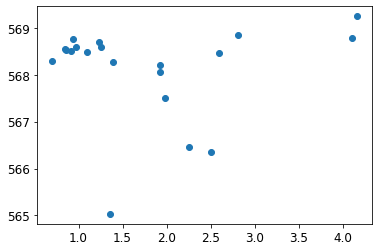

In [42]:
plt.scatter(data_scaled["z1_mod"], data_scaled["z2_mod"])

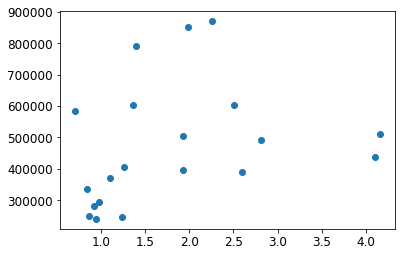

In [43]:
plt.scatter(data_scaled["z1_mod"], data_scaled["Tests_performed"])

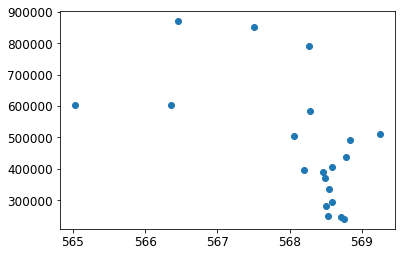

In [44]:
plt.scatter(data_scaled["z2_mod"], data_scaled["Tests_performed"])

It seems that if we take into account the tests performed we will be able to differentiate more teh clusters:

We now create a dendogram in order to do a hierarchical cluster analysis:

In [45]:
#Here we stored first the distances between the points
dist=sklearn.metrics.pairwise.euclidean_distances(data_scaled, squared=True) 

In [46]:
labels=regions_indicators_2020["Region_name"].to_list()
labels

['Abruzzo',
 'Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Friuli Venezia Giulia',
 'Lazio',
 'Liguria',
 'Lombardia',
 'Marche',
 'Molise',
 'Piemonte',
 'Puglia',
 'Sardegna',
 'Sicilia',
 'Toscana',
 'Trentino-Alto Adige',
 'Umbria',
 "Valle d'Aosta",
 'Veneto']

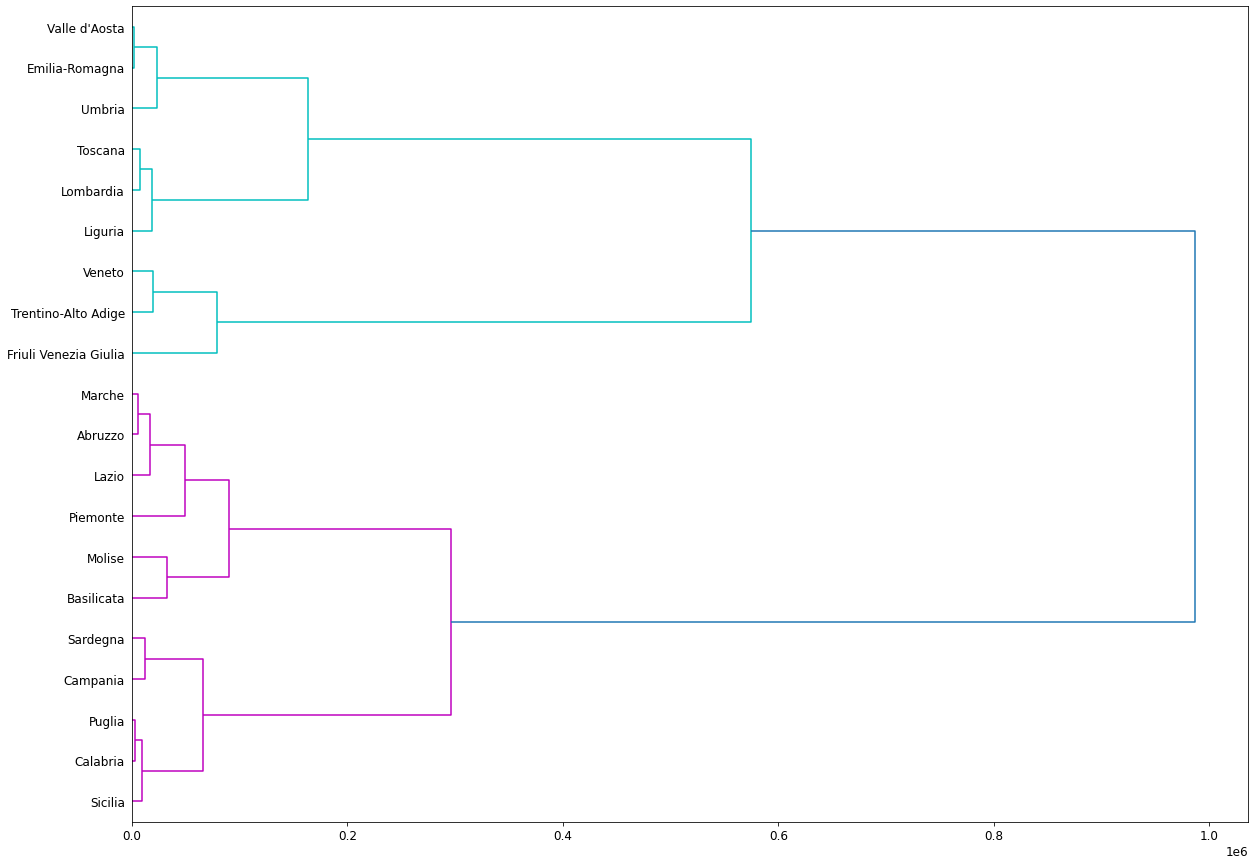

In [47]:
shc.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(20, 15))
dendrogram(shc.linkage(data_scaled, method="ward"),
            orientation='right',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig("../plots/regional_dendogram_2020.pdf",bbox_inches="tight")
plt.savefig('../img/regional_dendogram_2020.png', dpi=300, bbox_inches='tight')
plt.show()

We check what is the optimal number of clusters by computing the average silhouette width:

In [48]:
range_n_clusters = range(2,9)

for n_clusters in range_n_clusters:

    clusterer =AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage='ward') 
    cluster_labels = clusterer.fit_predict(data_scaled)

    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5551556275765688
For n_clusters = 3 The average silhouette_score is : 0.6314976199855132
For n_clusters = 4 The average silhouette_score is : 0.6623857356399998
For n_clusters = 5 The average silhouette_score is : 0.7114340803846394
For n_clusters = 6 The average silhouette_score is : 0.6618122146333297
For n_clusters = 7 The average silhouette_score is : 0.6167745632955125
For n_clusters = 8 The average silhouette_score is : 0.643062417089139


The optimal number of clusters seems to be 5, hence we apply hierarchical clustering for 5 clusters and then visualize the scatterplots with the created clusters:

In [49]:
cluster = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage='ward')  
preds=cluster.fit_predict(data_scaled)
preds

array([0, 0, 1, 1, 3, 2, 0, 4, 4, 0, 0, 0, 1, 1, 1, 4, 2, 3, 3, 2],
      dtype=int64)

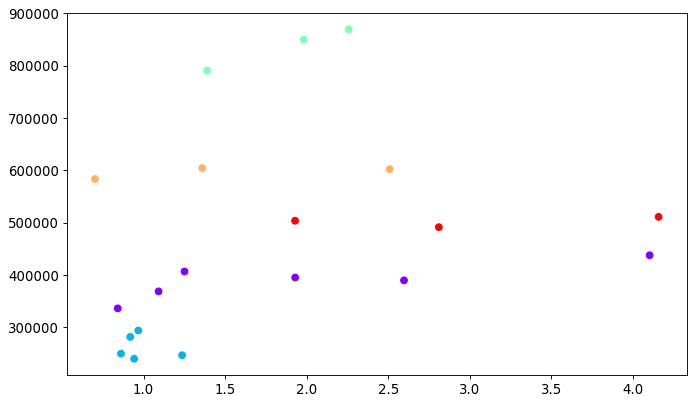

In [50]:
plt.figure(figsize=(10,6), dpi=80)
ax=plt.scatter(data_scaled["z1_mod"],data_scaled["Tests_performed"], c=cluster.labels_, cmap='rainbow')

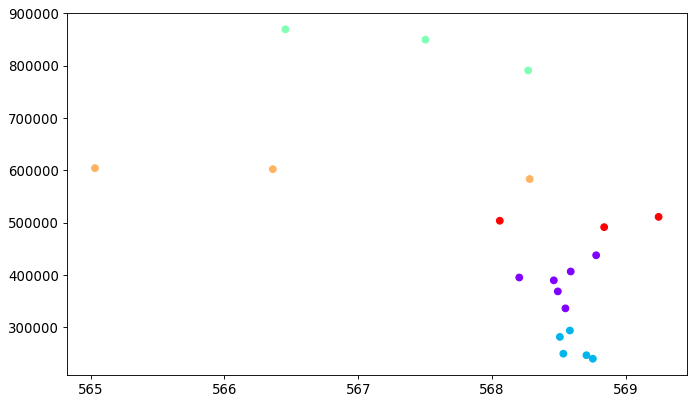

In [51]:
plt.figure(figsize=(10,6), dpi=80)
plt.scatter(data_scaled["z2_mod"],data_scaled["Tests_performed"], c=cluster.labels_, cmap='rainbow') 

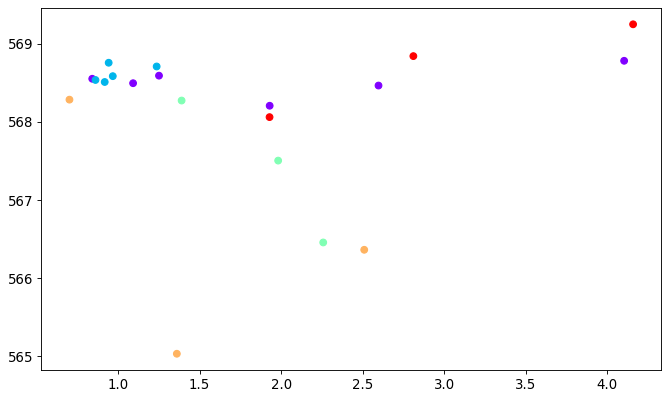

In [52]:
plt.figure(figsize=(10,6), dpi=80)
plt.scatter(data_scaled["z1_mod"],data_scaled["z2_mod"], c=cluster.labels_, cmap='rainbow') 

As said before it seems that the number of test helps to differentiate the clusters between them.

<a id='7b'></a>
### 7a. K-means

For the K-means algorithm the imports are:

In [53]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

In [54]:
X=data_scaled

We first do a pairplot, alternatively to plot the single 2D scatterplots:

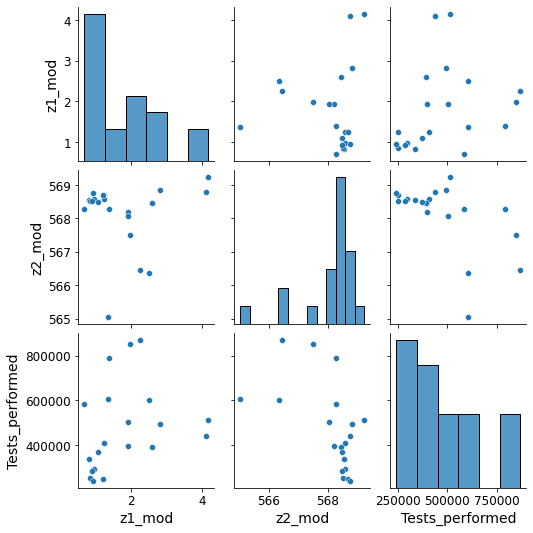

In [55]:
sns.pairplot(pd.DataFrame(X))

We will check the inertia and the silhouette scores for 2 to 8 clusters:

In [56]:
k_range = range(2,9)

In [57]:
distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(X)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X,y_km))

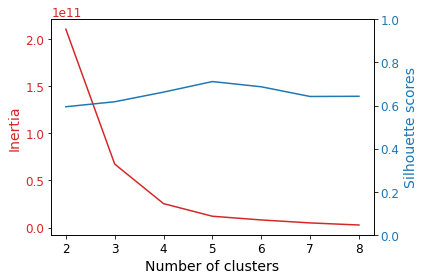

In [58]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

It seems that a good number of clusters could be of 5:

In [64]:
good_k = 5
km = KMeans(n_clusters=good_k, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)
y_km = km.fit_predict(X)
y_km

array([0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1, 2])

We compute the cluster centers (centroids):

In [65]:
km.cluster_centers_

array([[1.26374042e+00, 5.68538235e+02, 3.21106818e+05],
       [2.51056493e+00, 5.67799787e+02, 5.33597262e+05],
       [1.87651198e+00, 5.67409502e+02, 8.36834941e+05]])

After importing the function for plotting the clusters (Reference: Professor Claudio Sartori, Università di Bologna), we plot the obtained K-means clustering:

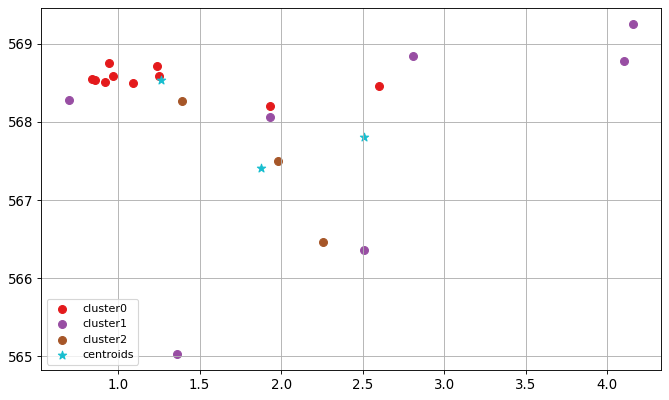

In [66]:
import plot_clusters as pc

pc.plot_clusters(X,y_km,dim=(0,1), points = km.cluster_centers_)
plt.savefig("../plots/k_means_region_2020.pdf",bbox_inches="tight")
plt.savefig('../img/k_means_region_2020.png', dpi=300,bbox_inches="tight")

plt.show()
#z1,z2
#regional prev, week tren

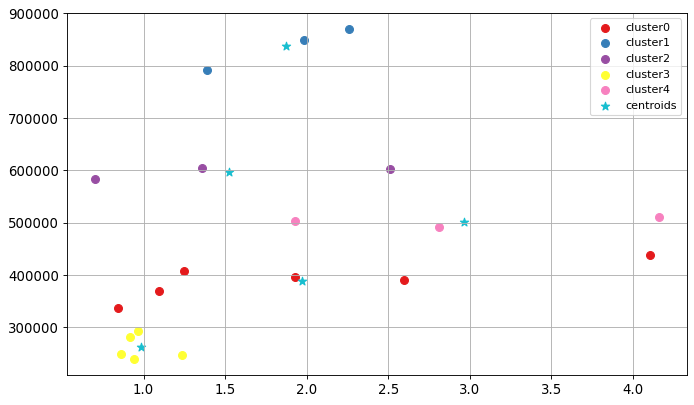

In [62]:
pc.plot_clusters(X,y_km,dim=(0,2), points = km.cluster_centers_)
#z1,test
#regional prev., test perform
plt.savefig("../plots/k_means_region_2_2020.pdf",bbox_inches="tight")
plt.savefig('../img/k_means_region_2_2020.png', dpi=300,bbox_inches="tight")

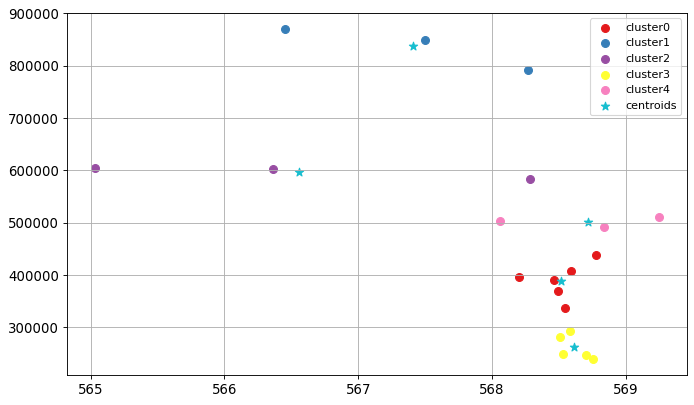

In [63]:
pc.plot_clusters(X,y_km,dim=(1,2), points = km.cluster_centers_)
#z2,test
#week trend, test performed

As before it seems that the number of tests performed have influenced a lot the discrimination between the clusters.